In [38]:

import hats
import pyarrow.parquet as pq
import numpy as np
from tqdm import tqdm

import hats.io.file_io as io
from hats.catalog import PartitionInfo
from hats.io import paths
from hats.io.parquet_metadata import write_parquet_metadata

from hats.catalog import TableProperties
from pathlib import Path

from datetime import datetime, timezone


/home/d/delucchi/.local/lib/python3.11/site-packages/hats/inspection/visualize_catalog.py:285: UserWarning: This plot contains HEALPix pixels smaller than a pixel of the plot. Some values may be lost
  warnings.warn(


(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Catalog pixel density map - DiaObject'}>)

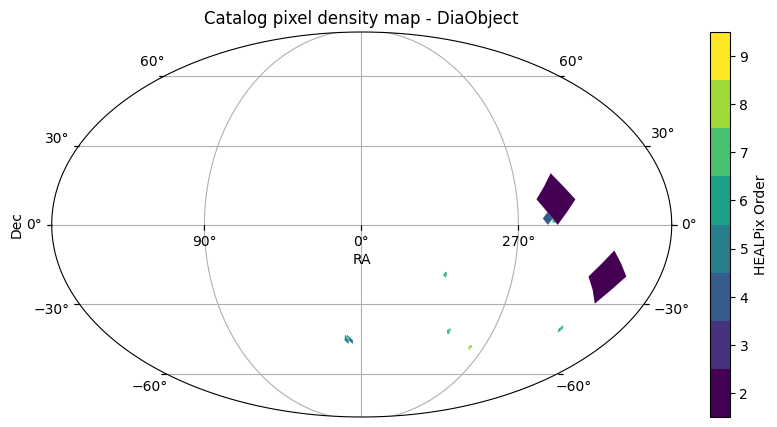

In [39]:
catalog = hats.read_hats("./DATA/hats/dia/DiaObject")
catalog.plot_pixels()

In [40]:
catalog.catalog_info.total_rows

12222552

We know from querying like:

```
        SELECT count(distinct("diaObjectId"))
        FROM DiaObject
```

That there are only 1_791_959 distinct objects, so around 85% of objects are duplicates. We could either use LSDB (or just some vanilla numpy/pyarrow operations), to de-duplicate the object table.

In [41]:
input_rows = 0
num_uniques = 0
output_rows = 0

for target_pixel in tqdm(catalog.get_healpix_pixels()):
    file_path = hats.io.pixel_catalog_file(catalog.catalog_base_dir, target_pixel)
    parquet_file = pq.ParquetFile(file_path)
    table = parquet_file.read()
    input_rows += len(table)

    unique, indices = np.unique(table["diaObjectId"].to_numpy(), return_index=True)
    num_uniques += len(unique)

    mask_array = np.zeros(len(table), dtype=int)
    mask_array[indices] = 1
    
    table = table.filter(mask_array ==1)
    output_rows += len(table)

    destination_dir = hats.io.pixel_directory(
                "./DATA/hats/dia/DiaObject-dedupe/", target_pixel.order, target_pixel.pixel        )
    hats.io.file_io.make_directory(destination_dir, exist_ok=True)
    
    out_path = hats.io.pixel_catalog_file("./DATA/hats/dia/DiaObject-dedupe/", target_pixel)
    
    pq.write_table(table, out_path)

100%|██████████| 102/102 [00:08<00:00, 12.15it/s]


In [42]:
print("input_rows", input_rows)
print("num_uniques", num_uniques)
print("output_rows", output_rows)


input_rows 12222552
num_uniques 1436990
output_rows 1436990


In [44]:
destination_path = Path("./DATA/hats/dia/DiaObject-dedupe/")

parquet_rows = write_parquet_metadata(destination_path)
print("parquet_rows", parquet_rows)
assert parquet_rows == output_rows

# Read partition info from _metadata and write to partition_info.csv
partition_info = PartitionInfo.read_from_dir(destination_path)
partition_info_file = paths.get_partition_info_pointer(destination_path)
partition_info.write_to_file(partition_info_file)

now = datetime.now(tz=timezone.utc)

catalog_info = TableProperties(
    catalog_name="DiaObject",
    total_rows=parquet_rows,
    hats_order=9,
    hats_builder = "Melissa DeLucchi",
    hats_creation_date= now.strftime("%Y-%m-%dT%H:%M%Z"),

    catalog_type="object",
    ra_column="ra",
    dec_column="dec",
)
catalog_info.to_properties_file(destination_path)

parquet_rows 1436990
